Pairs trading involves picking two stocks that are related in some way and profiting from the pricing differences between them. 

In [1]:
import math
import numpy as np
import matplotlib.pyplot  as plt
import yfinance as yf
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

# data = yf.download(tickers, start='2022-01-01', end='2025-01-01')

# prices = data['Close']

prices = pd.read_csv("prices.txt", sep='\s+', header=None, index_col=None)
tickers = [f"Stock {i+1}" for i in range(prices.shape[1])]

print(prices)

        0      1      2      3      4      5      6      7      8      9   \
0    38.25  69.06  62.08  31.80  63.01  28.30  36.93  43.23  42.31  67.37   
1    38.11  69.98  62.39  31.74  62.49  28.23  37.13  42.85  41.85  68.41   
2    37.90  69.56  62.82  31.57  62.74  28.60  36.57  42.99  41.48  69.84   
3    37.64  69.39  63.26  31.56  61.85  28.67  37.09  43.23  41.24  70.36   
4    37.70  69.71  64.04  31.42  62.02  28.42  37.09  42.90  41.40  69.12   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
745  36.49  51.34  45.11  29.37  39.73  28.69  17.89  47.71  40.70  58.56   
746  36.30  50.95  44.66  29.32  39.85  28.59  17.84  47.31  40.32  58.05   
747  36.58  50.80  44.25  29.17  40.01  28.97  17.76  47.01  39.97  57.61   
748  36.43  51.19  44.02  29.11  40.01  28.54  17.69  45.68  39.86  59.06   
749  36.24  50.64  43.43  29.01  40.03  28.70  17.69  46.00  39.78  59.52   

     ...     40     41     42     43     44     45     46     47     48    

[(0, 40), (1, 48), (1, 49), (2, 6), (2, 20), (2, 22), (6, 18), (6, 22), (7, 13), (8, 11), (8, 12), (8, 13), (8, 19), (8, 21), (8, 25), (8, 34), (8, 35), (8, 37), (8, 39), (8, 40), (8, 44), (8, 47), (8, 48), (8, 49), (11, 13), (11, 23), (11, 35), (15, 18), (16, 29), (18, 20), (18, 22), (18, 26), (18, 29), (18, 30), (18, 38), (18, 42), (18, 43), (18, 45), (20, 22), (22, 29), (25, 28), (25, 35), (25, 36), (25, 41), (25, 45), (25, 48), (25, 49), (26, 28), (26, 42), (26, 45), (26, 48), (29, 42), (33, 35), (33, 36), (33, 38), (33, 40), (33, 42), (33, 44), (33, 45), (33, 46), (33, 47), (33, 48), (33, 49), (37, 38), (37, 39), (37, 40), (37, 41), (37, 42), (37, 44), (37, 45), (37, 46), (37, 47), (37, 48), (37, 49), (48, 49)]


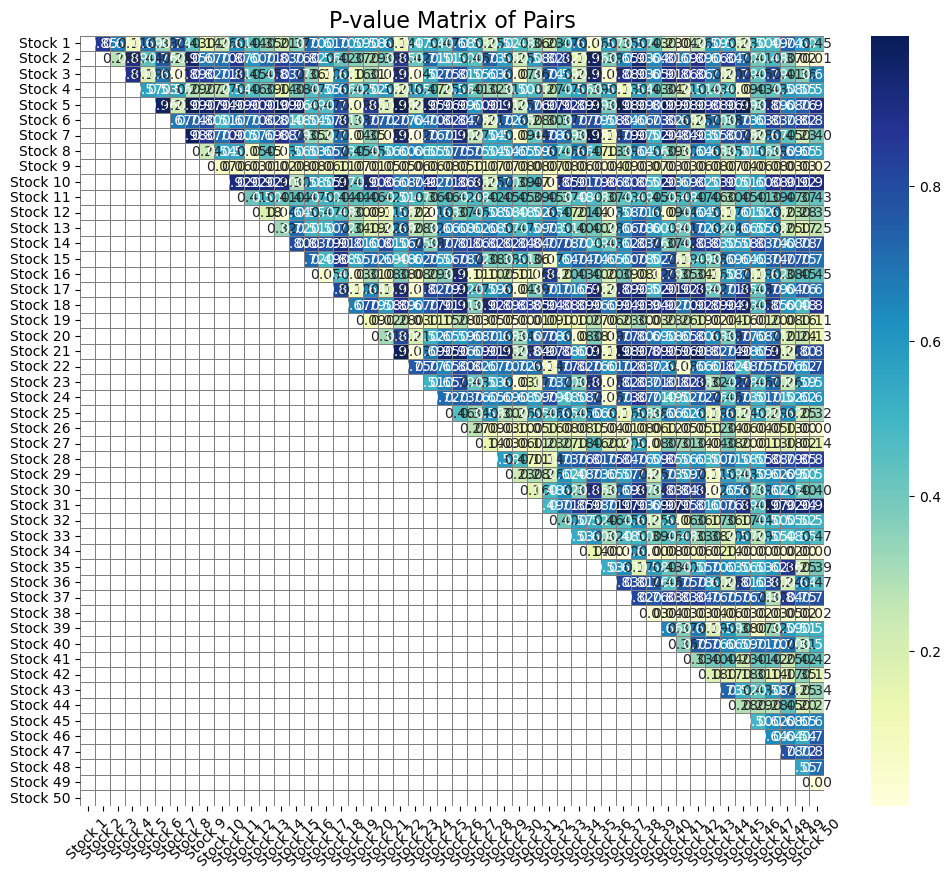

In [2]:

# start by running a cointegration test between chosen list of stocks/securities

def find_cointegrated_pairs(data):
    n = data.shape[1]
    # print(n)
    keys = data.keys()
    # print(keys)
    pvalue_matrix = np.ones((n, n))
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            coint_val, p_val, _ = coint(s1, s2)
            pvalue_matrix[i, j] = p_val
            if p_val < 0.05:
                pairs.append((keys[i], keys[j]))
    return pairs, pvalue_matrix
    

res, pvalue_matrix = find_cointegrated_pairs(prices)
print(res)

def plot_p_val_matrix(p_val_matrix, tickers):
    # Make a mask for the upper triangle
    mask = np.tril(np.ones_like(p_val_matrix, dtype=bool))
    
    plt.figure(figsize=(12,10))
    
    # Custom colormap: yellow → green → blue
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    
    sns.heatmap(
        p_val_matrix,
        mask=mask,               # mask upper triangle
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar=True,
        xticklabels=tickers,
        yticklabels=tickers,
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title("P-value Matrix of Pairs", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_p_val_matrix(pvalue_matrix, tickers)

In [3]:
# stationarity test
def stationarity_test(x, cutoff=0.05):
    # H_0: non stationarity
    # H_1: low enough p val for stationarity
    pvalue = adfuller(x)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + str(x.name) +' is likely stationary.')
        return True
    print('p-value = ' + str(pvalue) + ' The series ' + str(x.name) +' is likely non-stationary.')
    return False
        
        

# get stocks that are cointegrated and add them all to a set:

def test_stationarity_on_cointegrated_pairs(coint_pairs, data):
    res = []
    for coint_pair in coint_pairs:
        s1 = data[coint_pair[0]]
        s2 = data[coint_pair[1]]
        is_stationary_s1 = stationarity_test(s1)
        is_stationary_s2 = stationarity_test(s2)
        print()
        if is_stationary_s1 and is_stationary_s2:
            res.append((coint_pair[0], coint_pair[1]))
    return res


valid_pairs = test_stationarity_on_cointegrated_pairs(res, prices)
print(valid_pairs)
        

p-value = 0.32232283206583623 The series 0 is likely non-stationary.
p-value = 0.21889267295068893 The series 40 is likely non-stationary.

p-value = 0.5443149915051727 The series 1 is likely non-stationary.
p-value = 0.039241234729545514 The series 48 is likely stationary.

p-value = 0.5443149915051727 The series 1 is likely non-stationary.
p-value = 0.22371405533027094 The series 49 is likely non-stationary.

p-value = 0.6948075705377454 The series 2 is likely non-stationary.
p-value = 0.6907188536917088 The series 6 is likely non-stationary.

p-value = 0.6948075705377454 The series 2 is likely non-stationary.
p-value = 0.9377622190750895 The series 20 is likely non-stationary.

p-value = 0.6948075705377454 The series 2 is likely non-stationary.
p-value = 0.6391335780686169 The series 22 is likely non-stationary.

p-value = 0.6907188536917088 The series 6 is likely non-stationary.
p-value = 0.10735195437032602 The series 18 is likely non-stationary.

p-value = 0.6907188536917088 The 

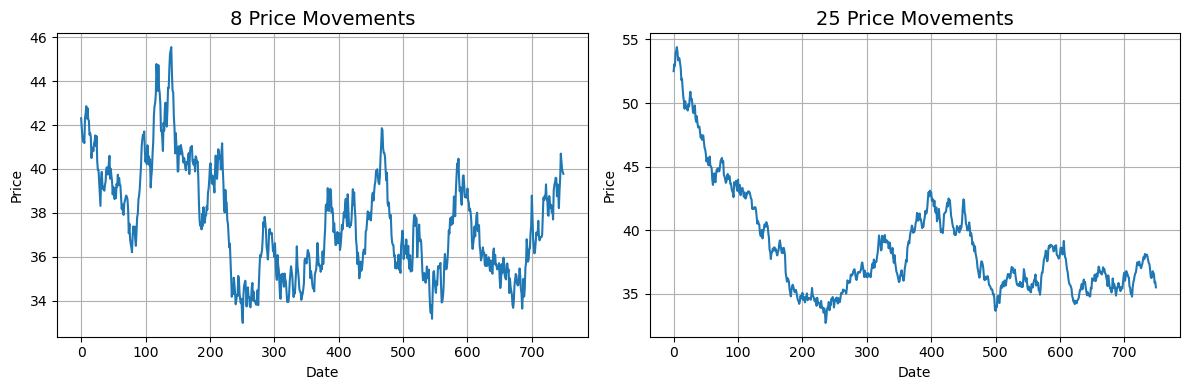

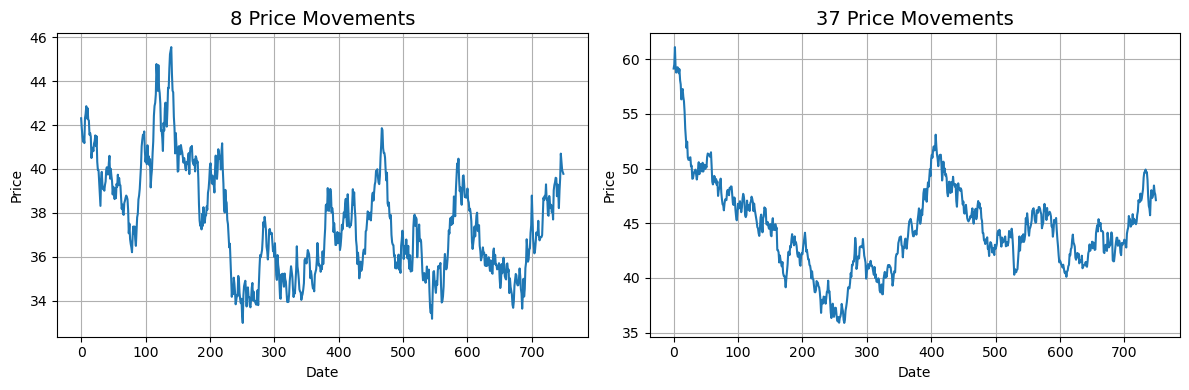

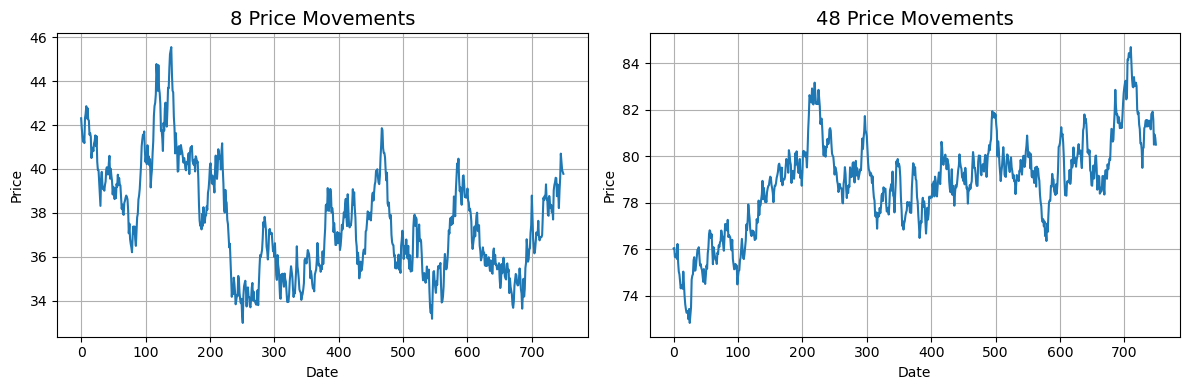

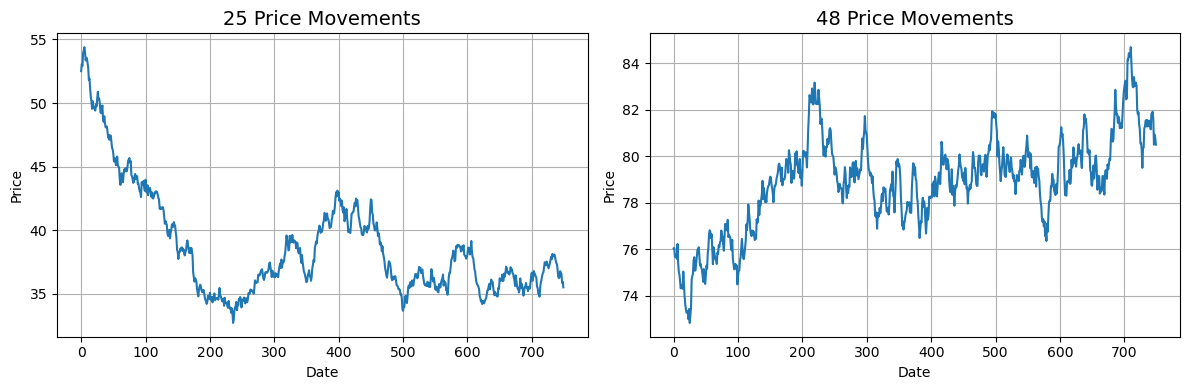

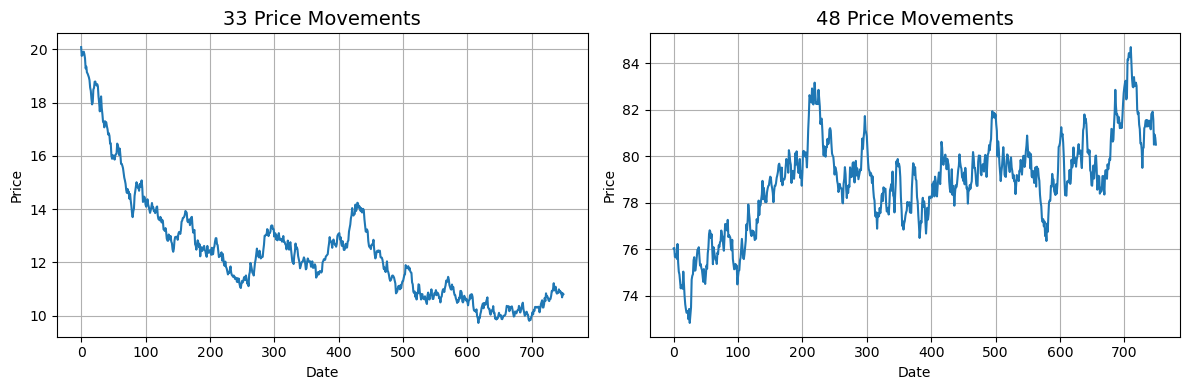

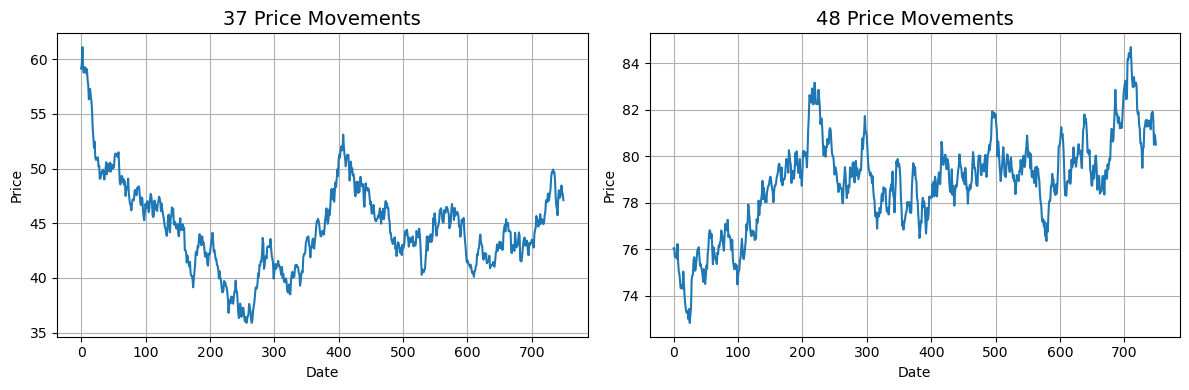

In [4]:
# price movements for each stock

def plot_stock_movements(pairs):
    for s1, s2 in pairs:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

        # Plot first stock
        axs[0].plot(prices[s1])
        axs[0].set_title(f"{s1} Price Movements", fontsize=14)
        axs[0].set_xlabel("Date")
        axs[0].set_ylabel("Price")
        axs[0].grid(True)

        # Plot second stock
        axs[1].plot(prices[s2])
        axs[1].set_title(f"{s2} Price Movements", fontsize=14)
        axs[1].set_xlabel("Date")
        axs[1].set_ylabel("Price")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()
        
plot_stock_movements(valid_pairs)


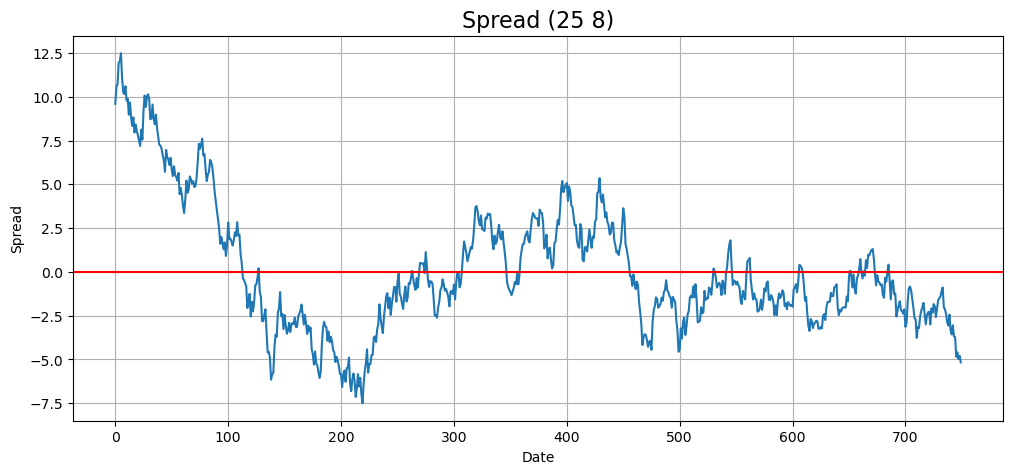

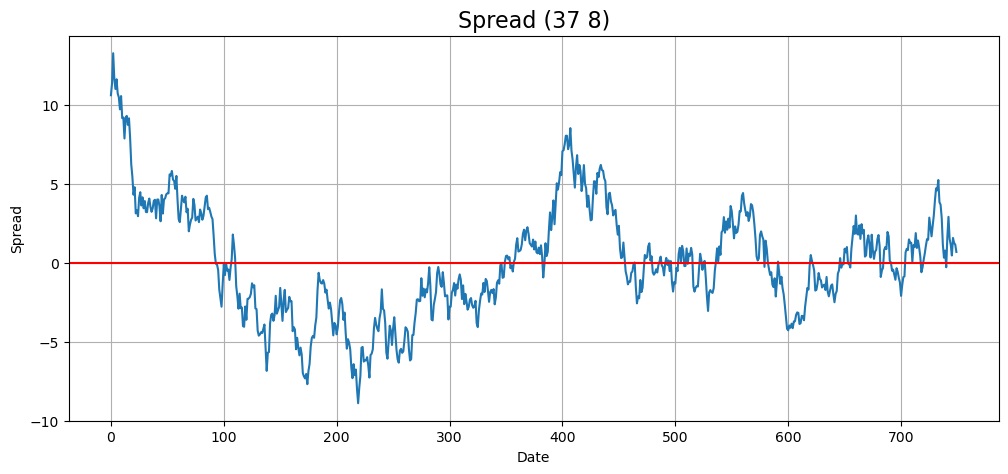

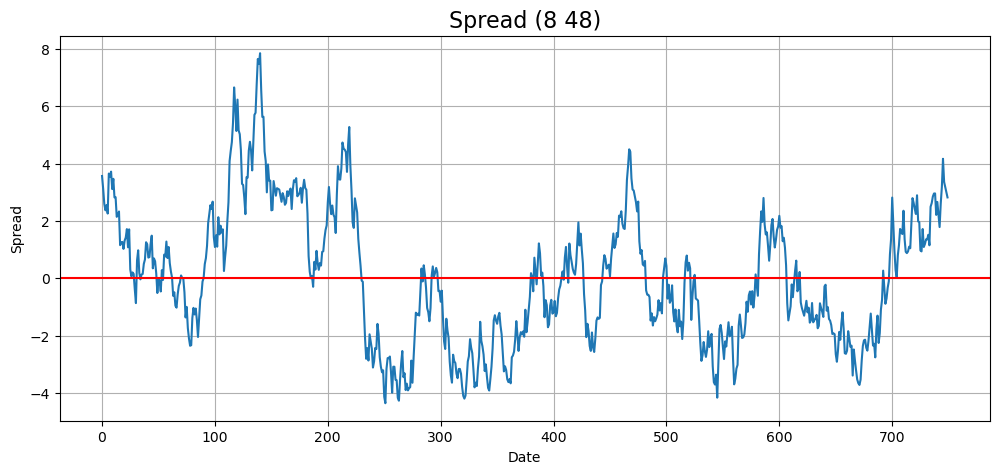

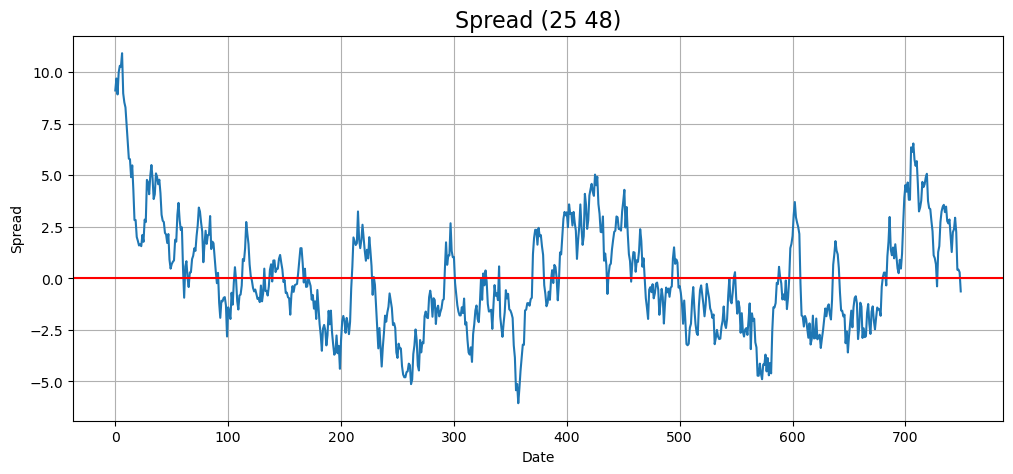

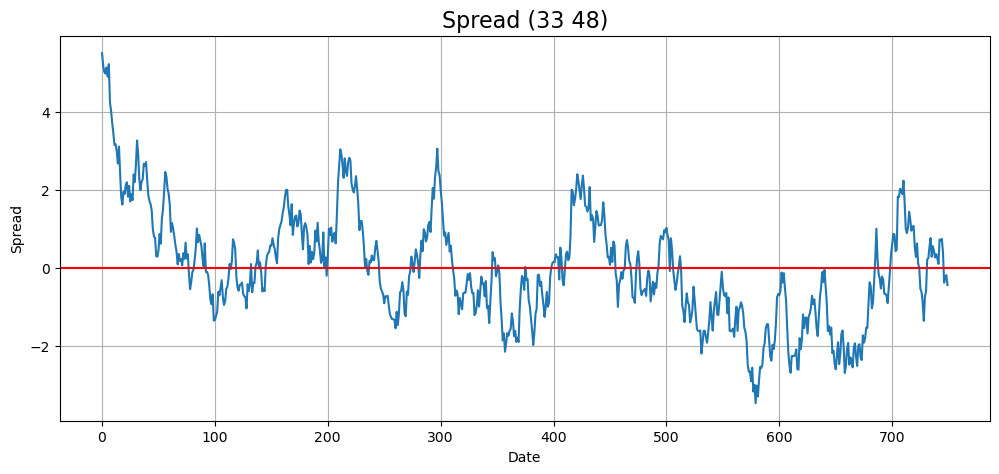

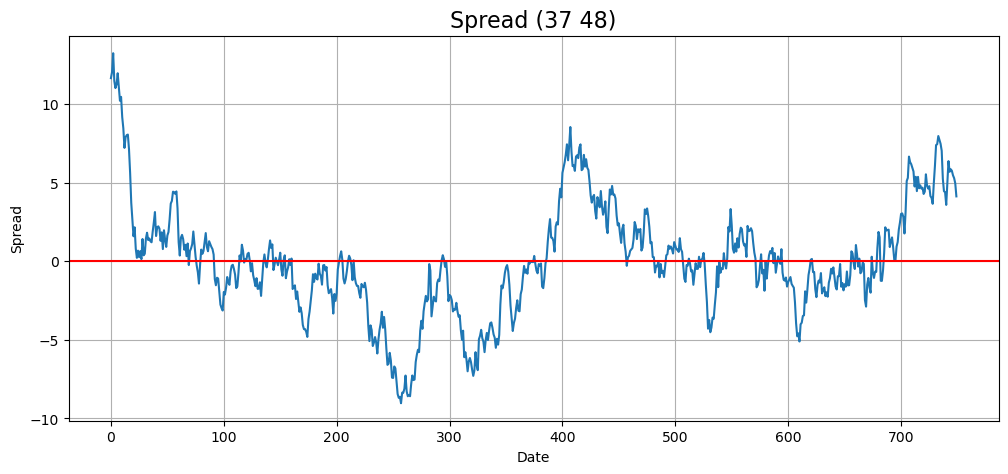

In [8]:
# calculate the spread for two securities 
# TODO: possibly plot ratios

def plot_spreads(pairs):
    spreads = []
    for s1, s2 in pairs:
        Y = None
        X = None
        if np.std(prices[s1]) > np.std(prices[s2]):
            Y = prices[s1]
            X = prices[s2]
        else:
            Y = prices[s2]
            X = prices[s1]
        X_const = sm.add_constant(X)
        model = sm.OLS(Y, X_const).fit()

        alpha = model.params["const"]
        beta = model.params[X.name]
        
        # Correct spread formula
        spread = Y - (alpha + beta * X)

        # Plot
        plt.figure(figsize=(12,5))
        plt.plot(spread)
        plt.title(f"Spread ({Y.name} {X.name})", fontsize=16)
        plt.xlabel("Date")
        plt.ylabel("Spread")
        plt.axhline(spread.mean(), color="red")
        plt.grid(True)
        plt.show()
        spreads.append((spread, X.name, Y.name))
    return spreads

spreads = plot_spreads(valid_pairs)


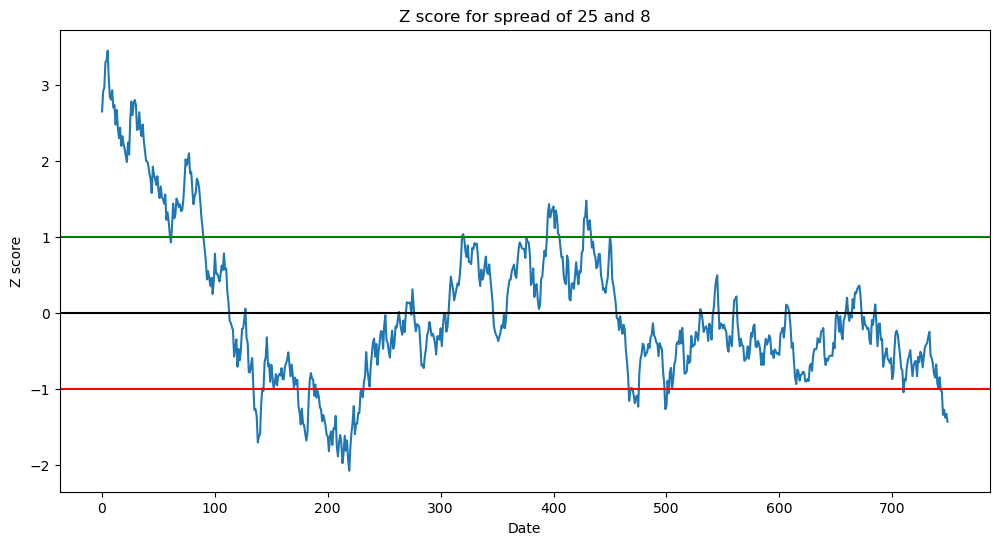

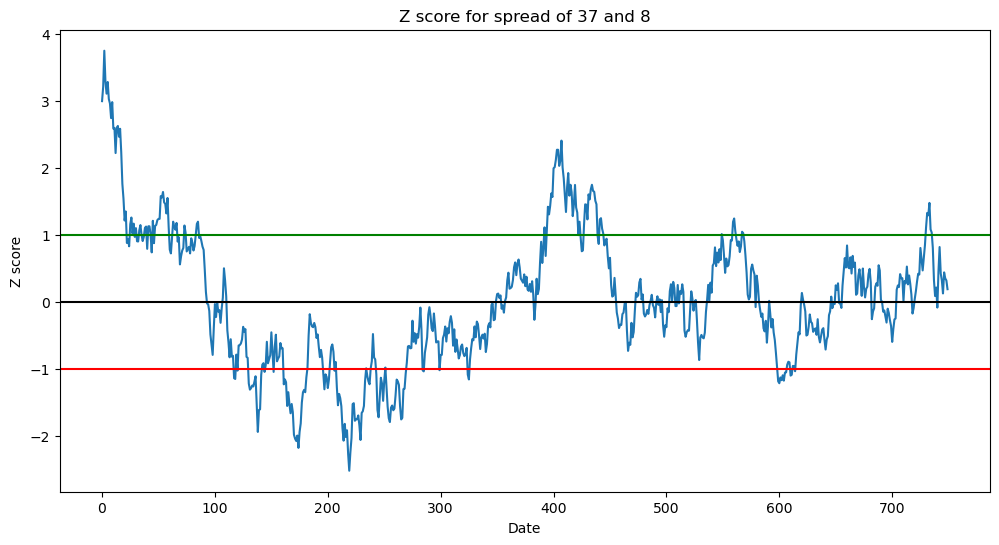

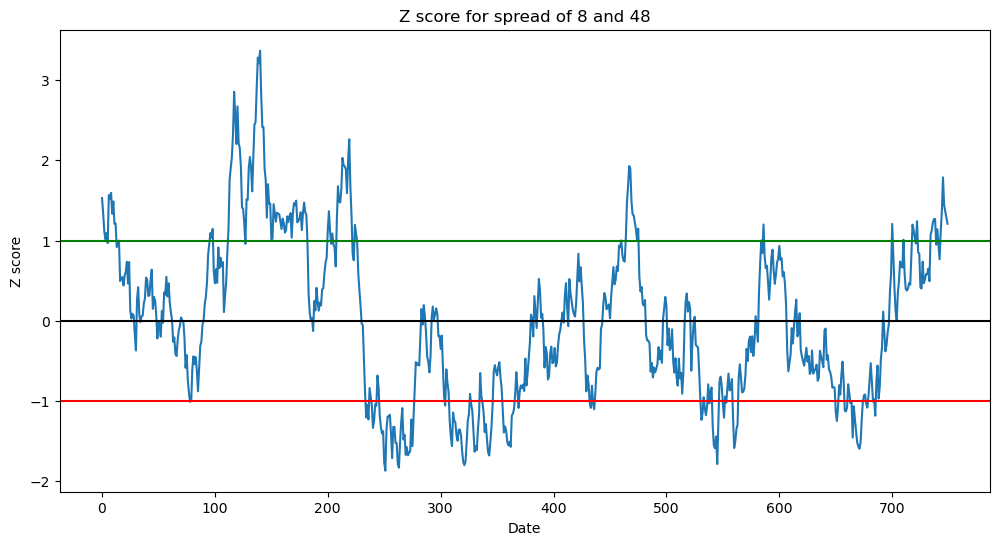

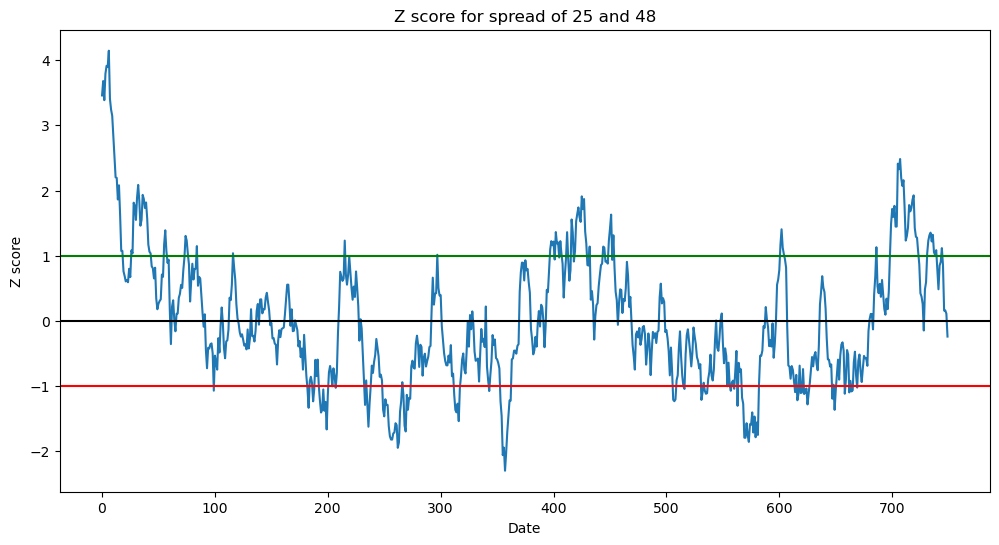

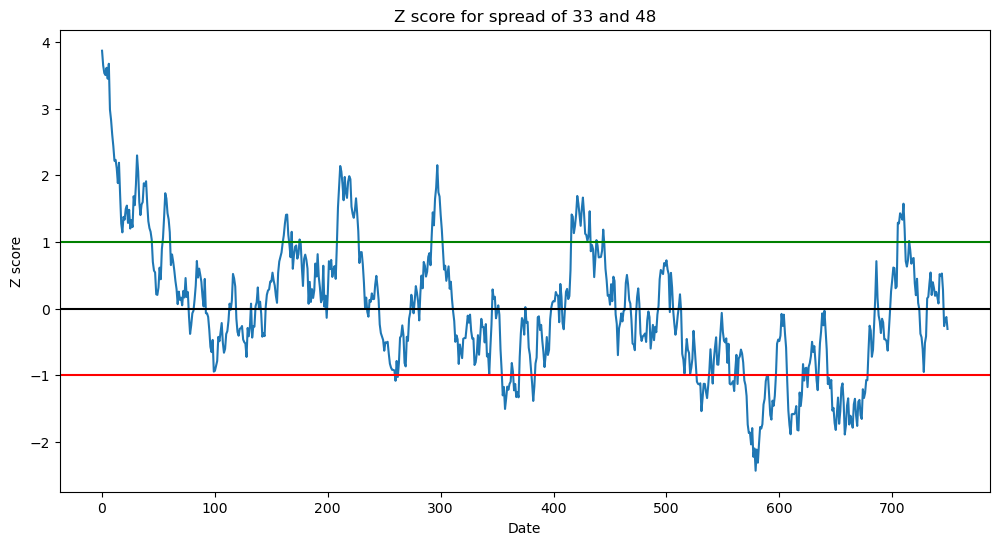

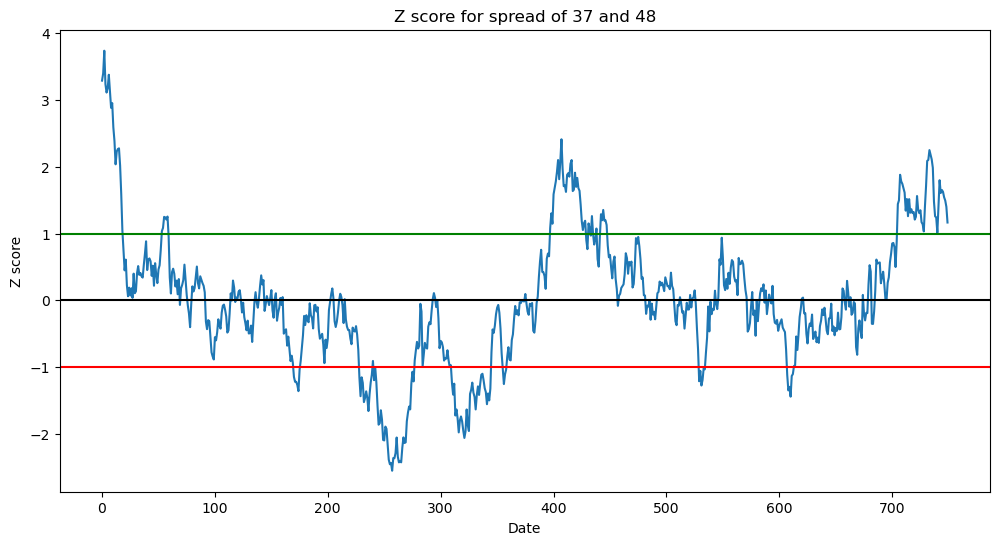

In [9]:
# calculate z scores for spreads

def zscore(series):
    return (series - series.mean()) / np.std(series)


def plot_zscores_for_spreads(spreads):
    for spread, X, Y in spreads:
        plt.figure(figsize=(12,6))
        plt.plot(zscore(spread))
        plt.title(f"Z score for spread of {Y} and {X}")
        plt.xlabel("Date")
        plt.ylabel("Z score")
        plt.axhline(1, color = 'green')
        plt.axhline(-1, color = 'red')
        plt.axhline(0, color = 'black')
        plt.show()
        
plot_zscores_for_spreads(spreads)


525.0


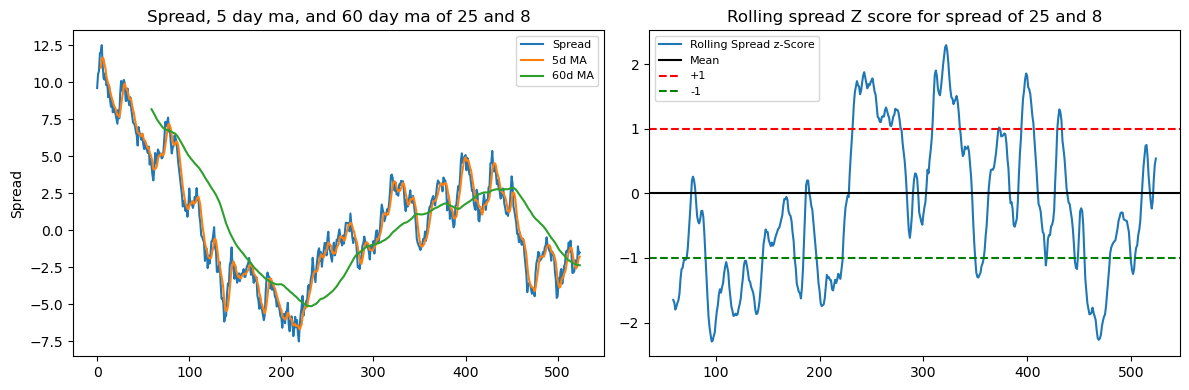

525.0


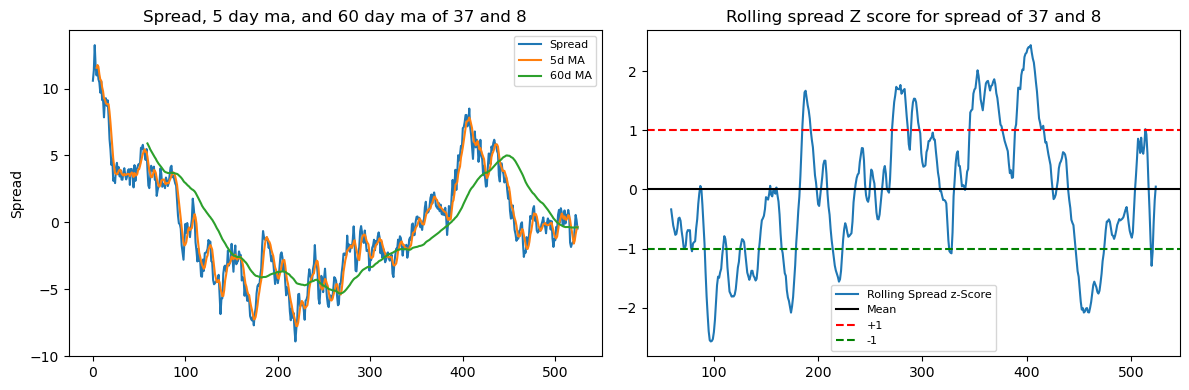

525.0


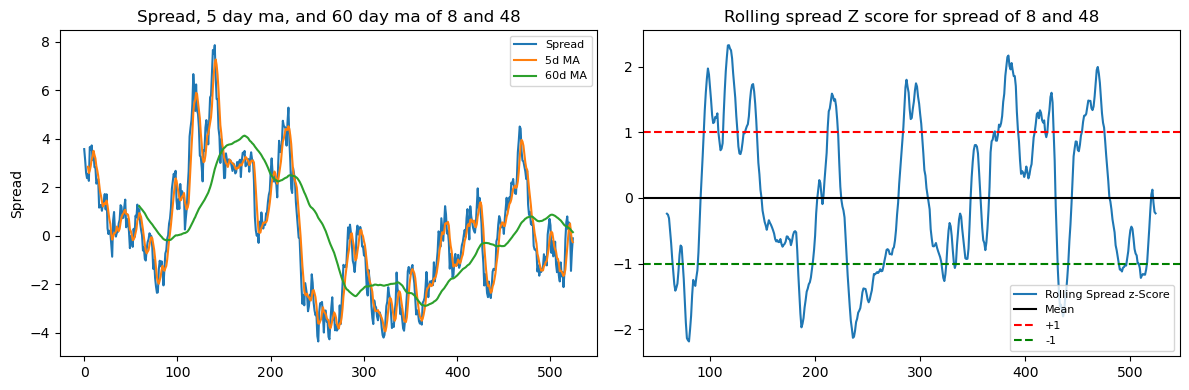

525.0


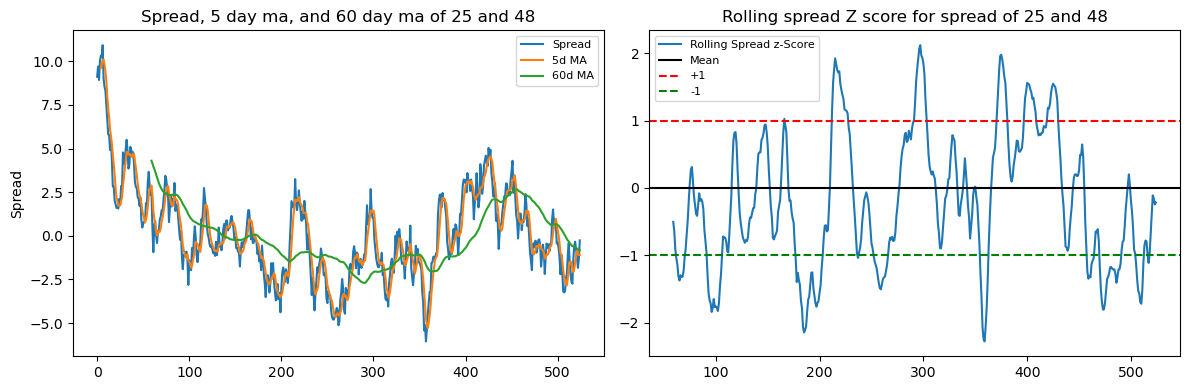

525.0


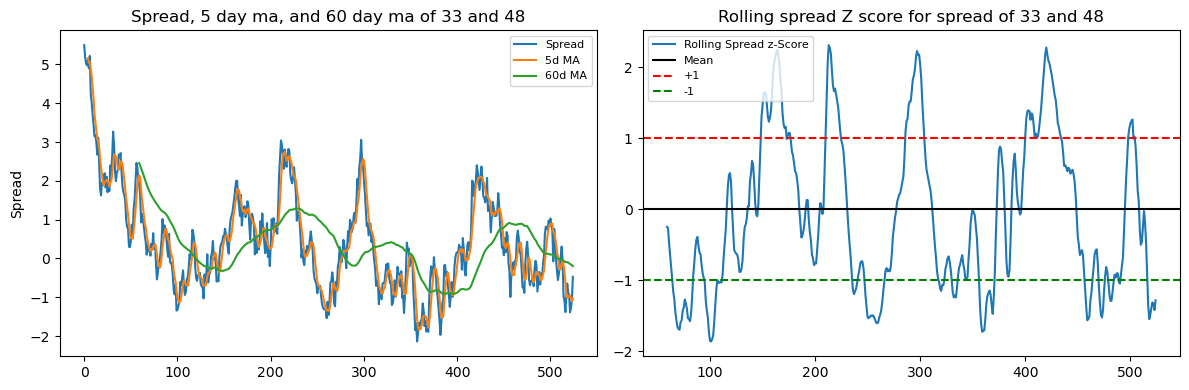

525.0


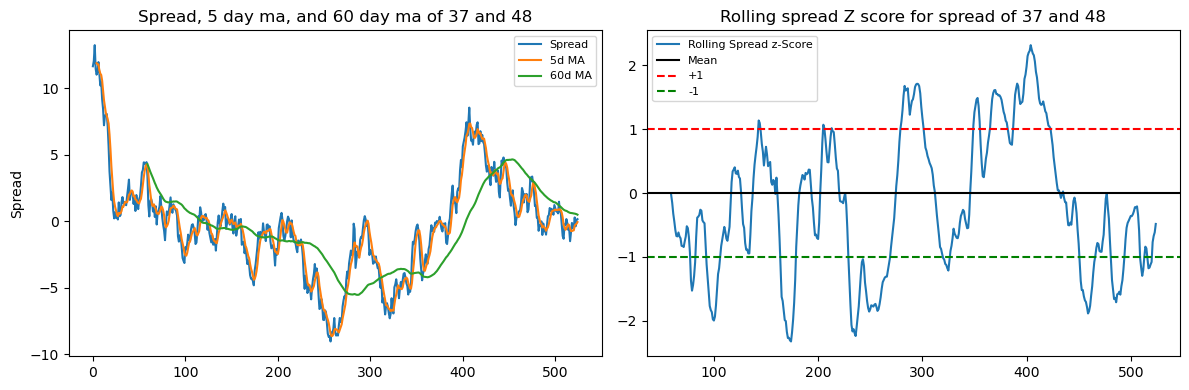

In [ ]:
def plot_rolling_ma_and_zscore(spreads):
    for spread, X, Y in spreads:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
        
        train_idx = len(spread) * .70
        print(train_idx)

        train = spread[:math.floor(train_idx)]
        test = spread[math.floor(train_idx):]

        moving_avg_5_day = train.rolling(window=5, center=False).mean()
        moving_avg_60_day = train.rolling(window=60, center=False).mean()
        std_60 = train.rolling(window=60, center=False).std()
        zscore_60_5 = (moving_avg_5_day - moving_avg_60_day)/std_60 # The z-score tells you how far the current spread deviates from its long-term mean, in units of standard deviations.
        axs[0].plot(train.index, train.values)
        axs[0].plot(moving_avg_5_day.index, moving_avg_5_day.values)
        axs[0].plot(moving_avg_60_day.index, moving_avg_60_day.values)
        axs[0].set_title(f"Spread, 5 day ma, and 60 day ma of {Y} and {X}")
        axs[0].legend(['Spread', '5d MA', '60d MA'], fontsize=8)
        axs[0].set_ylabel('Spread')

        axs[1].plot(zscore_60_5)
        axs[1].axhline(0, color='black')
        axs[1].axhline(1.0, color='red', linestyle='--')
        axs[1].axhline(-1.0, color='green', linestyle='--')
        axs[1].set_title(f"Rolling spread Z score for spread of {Y} and {X}")
        axs[1].legend(['Rolling Spread z-Score', 'Mean', '+1', '-1'], fontsize=8)
        
                
        plt.tight_layout()
        plt.show()
        
        
        
plot_rolling_ma_and_zscore(spreads)

525.0


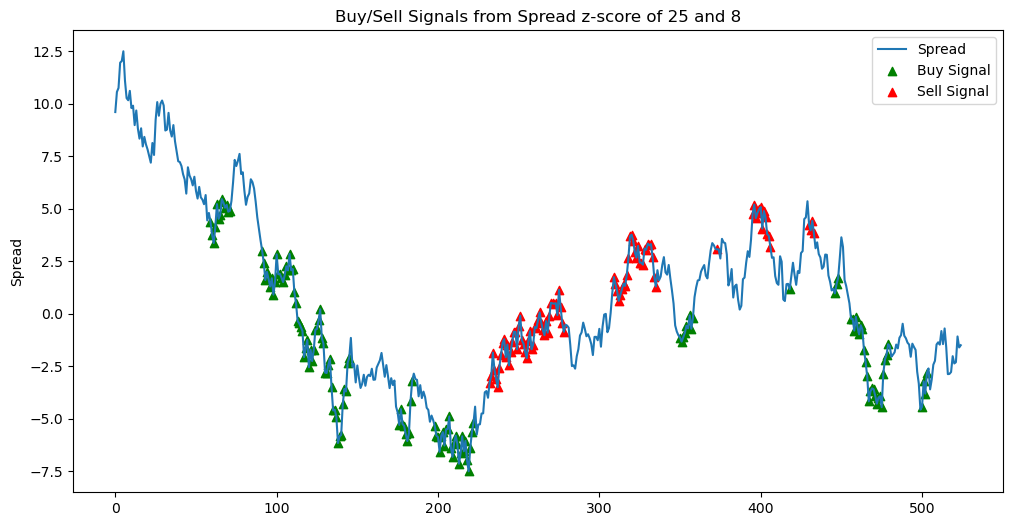

525.0


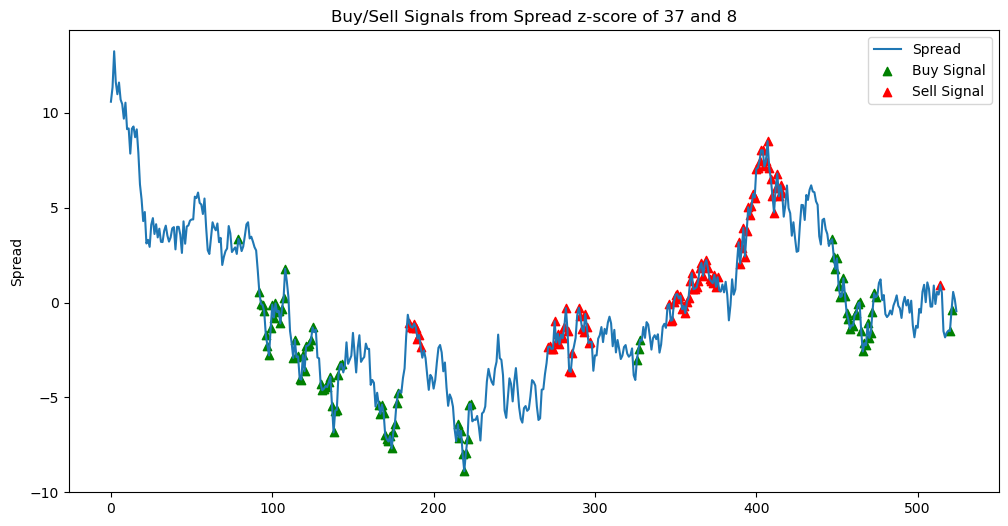

525.0


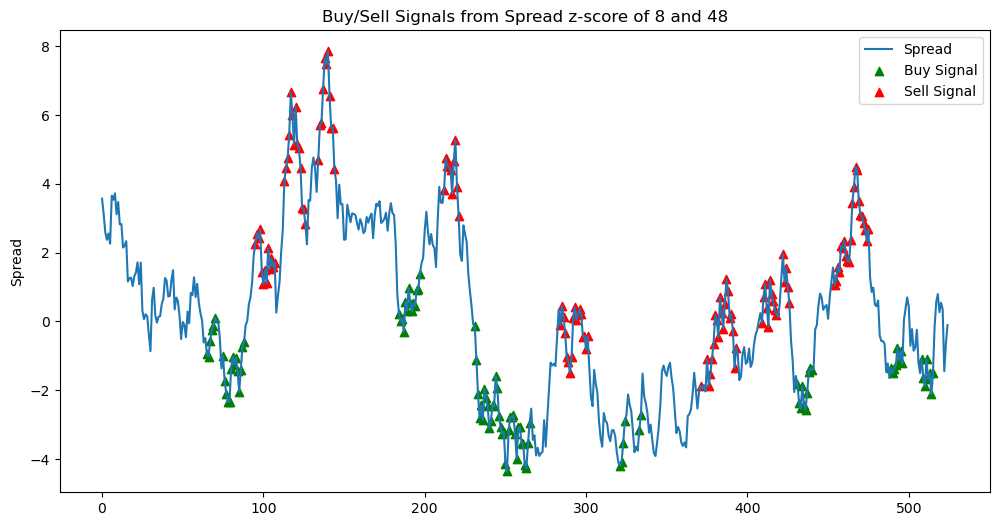

525.0


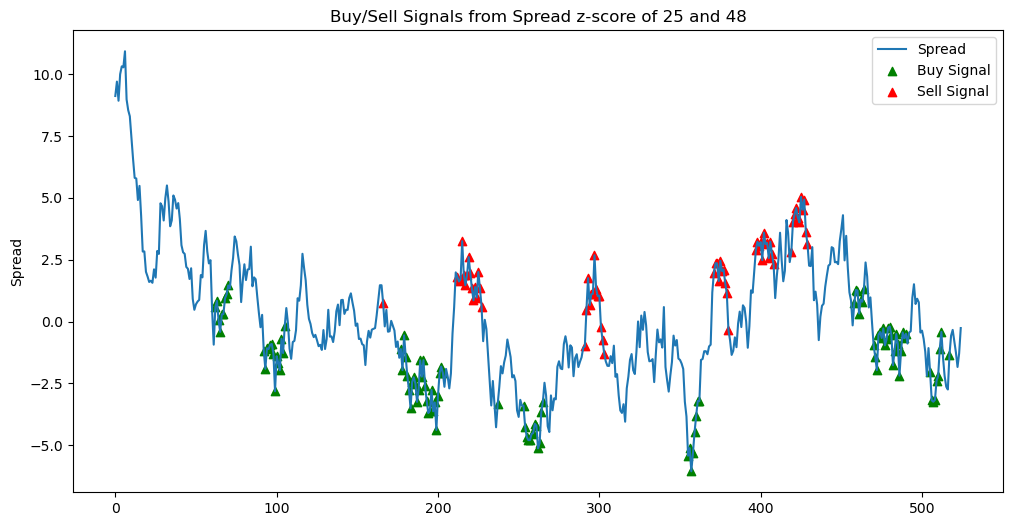

525.0


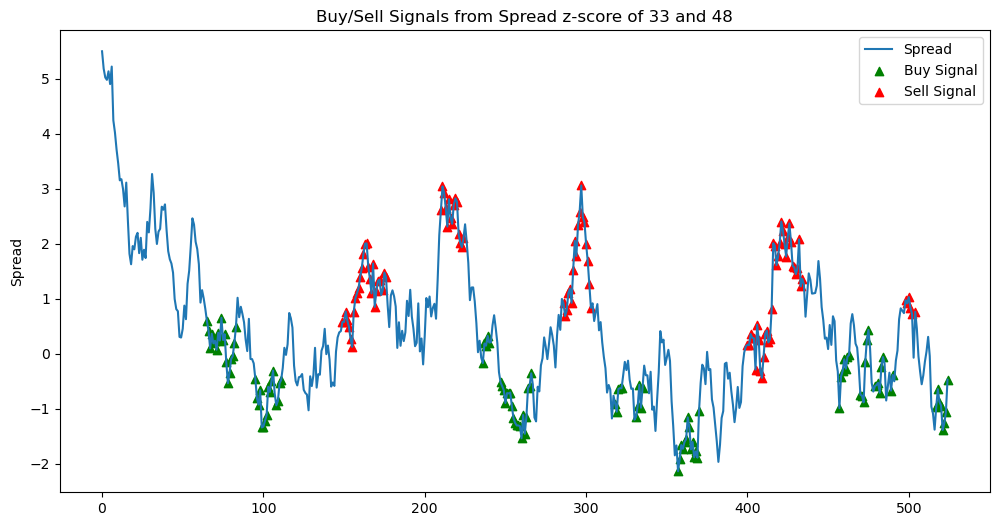

525.0


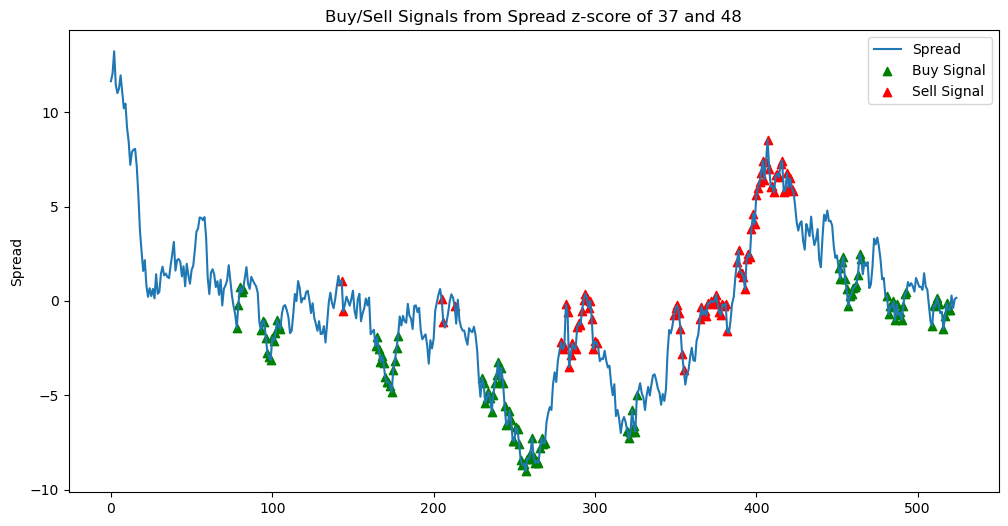

In [20]:
def plot_rolling_ma_and_zscore(spreads):
    for spread, X, Y in spreads:

        train_idx = len(spread) * .70
        print(train_idx)
        
        train = spread[:math.floor(train_idx)]
        test = spread[math.floor(train_idx):]
        
        moving_avg_5_day = train.rolling(window=5, center=False).mean()
        moving_avg_60_day = train.rolling(window=60, center=False).mean()
        std_60 = train.rolling(window=60, center=False).std()
        zscore_60_5 = (moving_avg_5_day - moving_avg_60_day)/std_60

        plt.figure(figsize=(12,6))

        # Plot the actual spread
        plt.plot(train.index, train.values, label='Spread')

        # Create buy & sell signal locations
        buy_signals = train[zscore_60_5 < -1]
        sell_signals = train[zscore_60_5 > 1]

        # Plot markers at actual spread values
        plt.scatter(buy_signals.index, buy_signals.values, color='green', marker='^', label='Buy Signal')
        plt.scatter(sell_signals.index, sell_signals.values, color='red', marker='^', label='Sell Signal')

        plt.legend()
        plt.title(f"Buy/Sell Signals from Spread z-score of {Y} and {X}")
        plt.ylabel("Spread")
        plt.show()
        
plot_rolling_ma_and_zscore(spreads)


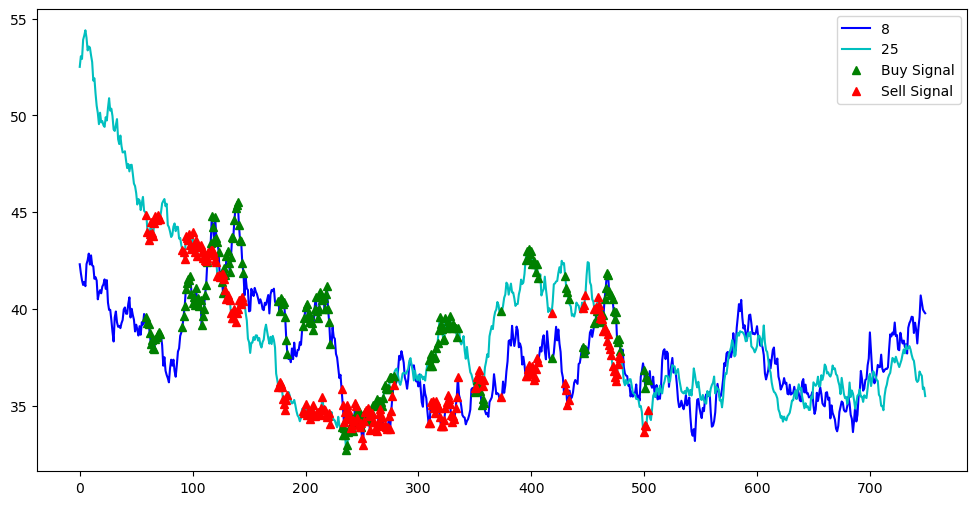

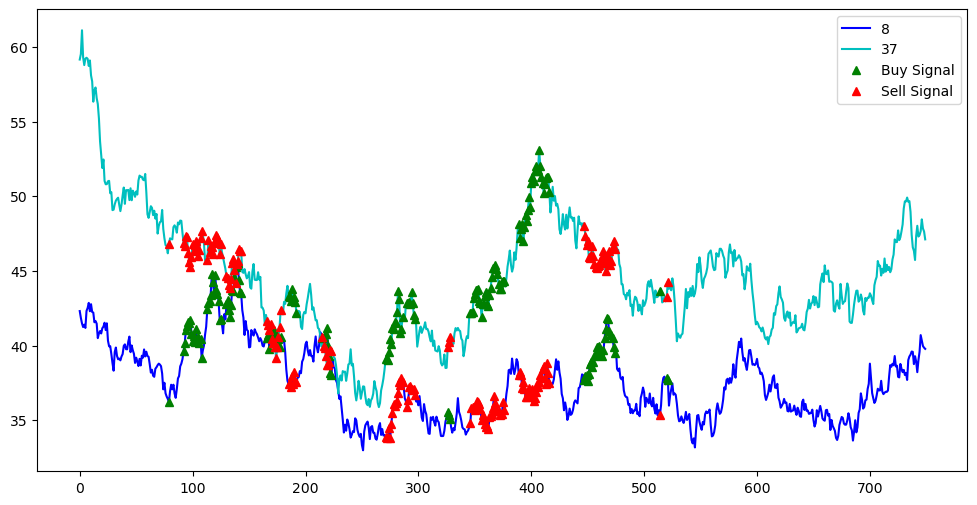

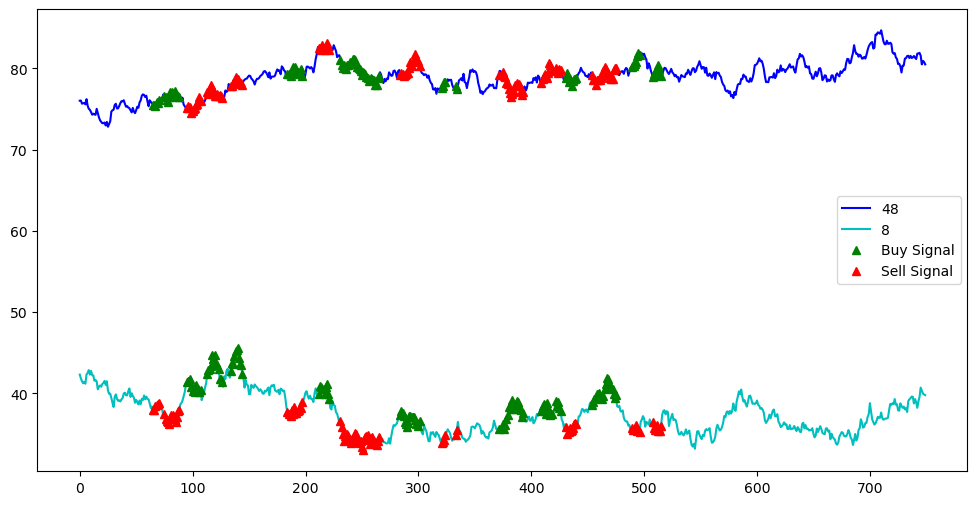

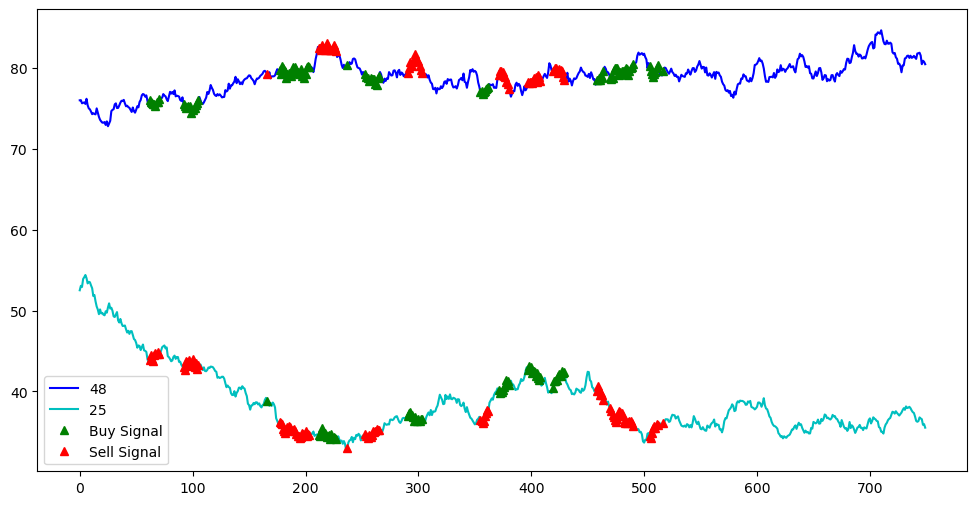

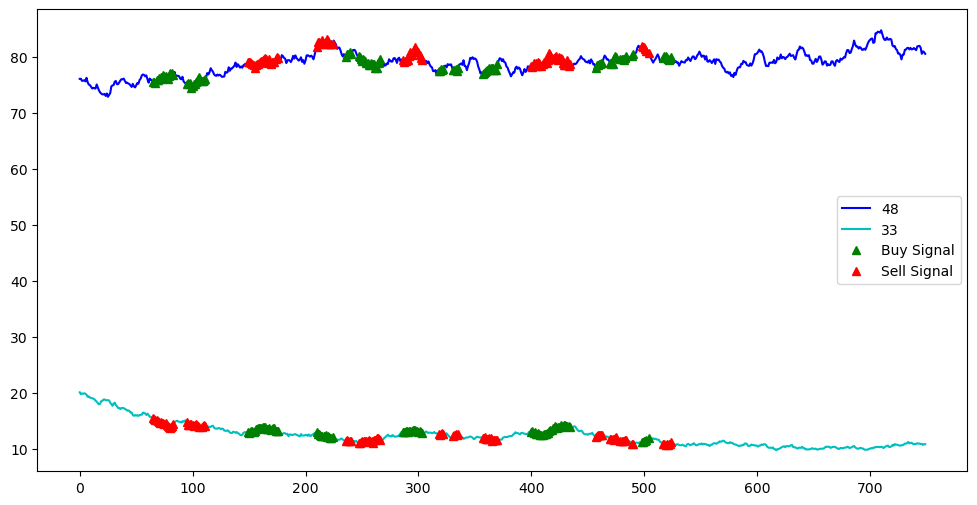

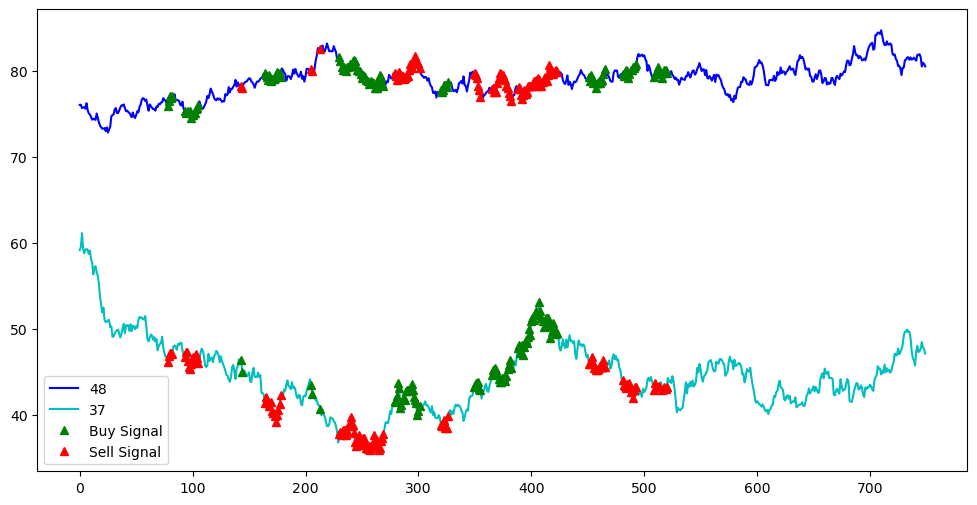

In [ ]:
def plot_trade_times(spreads):
    for spread, X, Y in spreads:

        train_idx = len(spread) * .70
        
        train = spread[:math.floor(train_idx)]
        test = spread[math.floor(train_idx):]
        
        moving_avg_5_day = train.rolling(window=5, center=False).mean()
        moving_avg_60_day = train.rolling(window=60, center=False).mean()
        std_60 = train.rolling(window=60, center=False).std()
        zscore_60_5 = (moving_avg_5_day - moving_avg_60_day)/std_60

        plt.figure(figsize=(12,6))

        # Create buy & sell signal locations
        buy_signals = train[zscore_60_5 < -1]
        sell_signals = train[zscore_60_5 > 1]
        
        s1 = prices[X] 
        s2 = prices[Y]
        
        s1_train = s1.loc[train.index]
        s2_train = s2.loc[train.index]
        
        s1.plot(color = 'b')
        s2.plot(color = 'c')

        buyR = pd.Series(np.nan, index=s1_train.index)
        sellR = pd.Series(np.nan, index=s1_train.index)
        
        buyR[buy_signals.index] = s1_train[buy_signals.index]
        sellR[buy_signals.index] = s2_train[buy_signals.index]
        
        buyR[sell_signals.index] = s2_train[sell_signals.index]
        sellR[sell_signals.index] = s1_train[sell_signals.index]
        

        buyR.plot(color='g', linestyle='None', marker='^')
        sellR.plot(color='r', linestyle='None', marker='^')
        
        plt.legend([X, Y, 'Buy Signal', 'Sell Signal'])
        plt.show()
        
        
plot_trade_times(spreads)

     